In addition to the Resilient Distributed Dataset (RDD) interface, the second kind of low-level API in Spark is two types of “distributed shared variables”:

*  Broadcast variables
*  Accumulators

 These are variables we can use in our user-defined functions (e.g., in a map
 function on an RDD or a DataFrame) that have special properties when running on a cluster

 Accumulators add together data from all the tasks into a shared result (e.g.,
 to implement a counter so you can see how many job’s input records failed to parse)



# Broadcast

Broadcast variables save a large value on all the worker nodes and reuse it across many Spark actions without re-sending it to the cluster

Broadcast variables are shared, immutable variables that are cached on every machine in the cluster instead of serialized with every single task

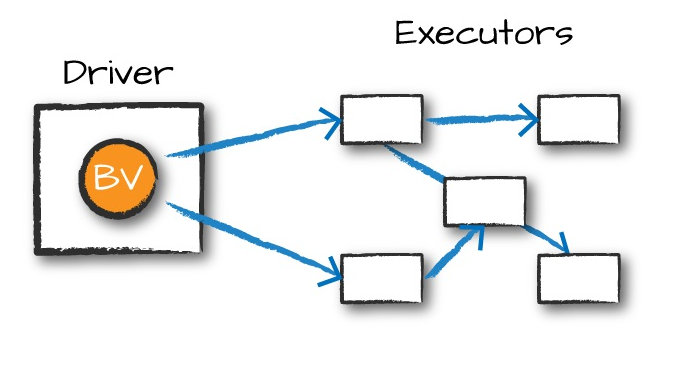

In [26]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("CSV_Read").getOrCreate()

In [5]:
my_collection = "Spark The Definitive Guide : Big Data Processing Made Simple".split(" ")

words = spark.sparkContext.parallelize(my_collection, 2) #creates an RDD with 2 partitions
print(words.collect())

['Spark', 'The', 'Definitive', 'Guide', ':', 'Big', 'Data', 'Processing', 'Made', 'Simple']


In [6]:
# small lookup data
country_map = {
    "IN": "India",
    "US": "United States",
    "UK": "United Kingdom",
    "DE": "Germany"
}

In [9]:
print(type(country_map))

<class 'dict'>


In [10]:
# creating a broadcast variable
broadcast_country_map = spark.sparkContext.broadcast(country_map)

In [15]:
print(type(broadcast_country_map))

<class 'pyspark.core.broadcast.Broadcast'>


In [17]:
# declare a large dataset
data = [
    ("A", "IN"),
    ("B", "US"),
    ("C", "UK"),
    ("D", "IN"),
    ("E", "DE"),
    ("F",  "FR")
]

rdd = spark.sparkContext.parallelize(data, 2) # rdd with 2 partitions

In [18]:
rdd.getNumPartitions()

2

In [19]:
def enrich(record):
  name, code = record
  # pick country code from broadcast variable - this is dictionary type here
  country_name = broadcast_country_map.value.get(code, "Unknown")
  return (name, country_name)

In [20]:
result = rdd.map(enrich)
print(result.collect())

[('A', 'India'), ('B', 'United States'), ('C', 'United Kingdom'), ('D', 'India'), ('E', 'Germany'), ('F', 'Unknown')]


In [23]:
small_data = [
    ("IN", "India"),
    ("US", "United States"),
    ("UK", "United Kingdom"),
    ("DE", "Germany")
]
small_df = spark.createDataFrame(small_data,["country_code", "country_name"])


In [24]:
large_data = [
    (1, "IN", 500),
    (2, "US", 300),
    (3, "UK", 700),
    (4, "IN", 200),
    (5, "DE", 1000)
]

large_df = spark.createDataFrame(
    large_data,
    ["user_id", "country_code", "amount"]
)


In [25]:
from pyspark.sql.functions import broadcast

result = large_df.join(broadcast(small_df),"country_code")
result.show()

+------------+-------+------+--------------+
|country_code|user_id|amount|  country_name|
+------------+-------+------+--------------+
|          IN|      1|   500|         India|
|          US|      2|   300| United States|
|          UK|      3|   700|United Kingdom|
|          IN|      4|   200|         India|
|          DE|      5|  1000|       Germany|
+------------+-------+------+--------------+



#  Accumulators

Updating a value inside of a variety of transformations and propagating that value to the driver node in an efficient and fault-tolerant way

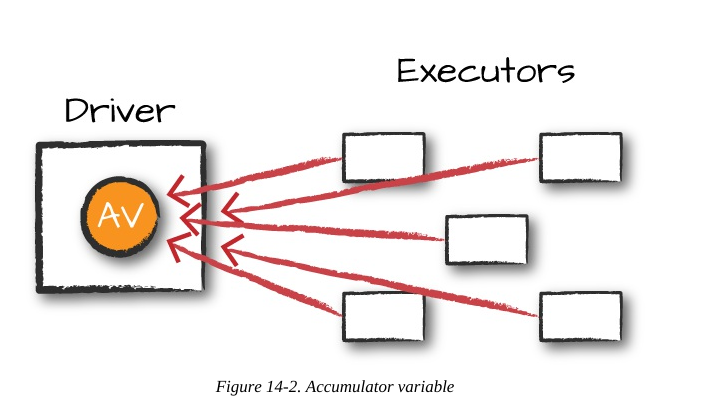

Accumulators provide a mutable variable that a Spark cluster can safely update on a per-row basis.

Spark natively supports accumulators of numeric types

Accumulator updates performed inside actions only

Spark guarantees that each task’s update to the accumulator will be applied only once, meaning that restarted tasks will not update the value. In transformations, you should be aware that each task’s update can be applied more than once if tasks or job stages are reexecuted

Accumulators do not change the lazy evaluation model of Spark.

Accumulators can be both named and unnamed. Named accumulators will display their running results in the Spark UI, whereas unnamed ones will not

This is used for debugging purpose , do not put business logic



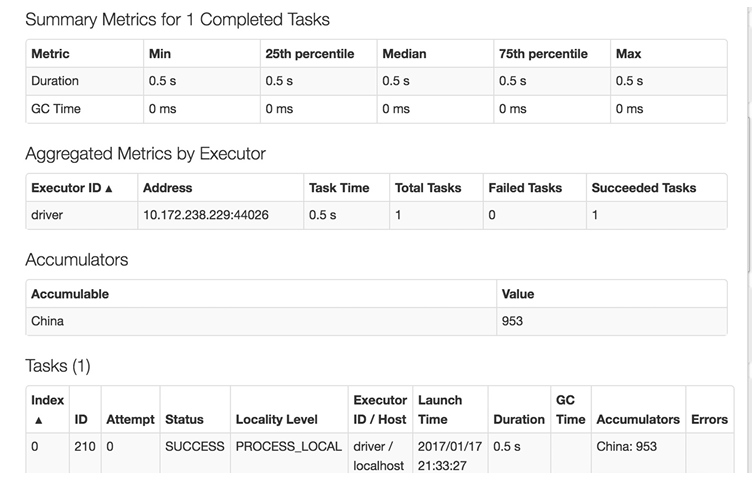

In [27]:

data = [
    (1, "IN", 500),
    (2, "US", 300),
    (3, "UK", None),
    (4, "IN", 200),
    (5, "DE", 1000),
    (6, "US", None)
]

df = spark.createDataFrame(
    data,
    ["user_id", "country_code", "amount"]
)

In [28]:
from pyspark.sql.functions import col

null_count = spark.sparkContext.accumulator(0)

def check_null(row):
    if row["amount"] is None:
        null_count.add(1)

df.foreach(check_null)

print("Null rows:", null_count.value)

Null rows: 2
